In [1]:
import os
import sys

# Add the parent directory of the 'playground' folder to the Python path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, PROJECT_ROOT)

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import SegformerForSemanticSegmentation
from utils.data_loader import get_train_data_loaders
from tqdm import tqdm

import matplotlib.pyplot as plt


In [2]:
class SegformerTrainer:
    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Setup data loaders
        self.train_loader, self.val_loader = self._setup_data_loaders(
            img_path=config['img_path'],
            gt_path=config['gt_path'],
            validation_split=config['val_split'],
            batch_size=config['batch_size']
        )

        # Initialize model
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            config['model_name'],
            num_labels=config['num_classes'],
            id2label={str(i): label for i, label in enumerate(config['class_names'])},
            label2id={label: str(i) for i, label in enumerate(config['class_names'])}
        )
        self.model = self.model.to(self.device)

        # Setup optimizer and scheduler
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )

        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=config['epochs'],
            eta_min=config['min_lr']
        )

        # Setup loss function with class weights
        class_weights = self._calculate_class_weights()
        self.criterion = nn.CrossEntropyLoss(weight=class_weights.to(self.device))

        # Add tracking lists for metrics
        self.train_losses = []
        self.val_losses = []

    def _setup_data_loaders(self, img_path, gt_path, validation_split, batch_size):
        """
        Helper function to set up data loaders.
        """
        if not os.path.exists(img_path) or not os.path.exists(gt_path):
            raise FileNotFoundError(f"Paths {img_path} or {gt_path} do not exist.")

        return get_train_data_loaders(
            img_dir=img_path,
            gt_dir=gt_path,
            validation_split=validation_split,
            batch_size=batch_size
        )

    def _calculate_class_weights(self):
        """
        Helper function to calculate class weights for the loss function.
        Modify this function if you have a specific way to compute class weights.
        """
        # Example: Uniform weights (1 for each class).
        num_classes = self.config['num_classes']
        return torch.ones(num_classes)

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        
        pbar = tqdm(self.train_loader, desc='Training')
        for batch_idx, (images, masks) in enumerate(pbar):
            images = images.to(self.device)
            masks = masks.to(self.device)
            
            self.optimizer.zero_grad()
            
            outputs = self.model(pixel_values=images, labels=masks)

            # Resize model outputs to match mask dimensions
            logits_upsampled = nn.functional.interpolate(
                outputs.logits,
                size=masks.shape[-2:],  # (512, 512)
                mode='bilinear',
                align_corners=False
            )
            loss = self.criterion(logits_upsampled, masks)
            
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        return total_loss / len(self.train_loader)

    def validate(self):
        self.model.eval()
        total_loss = 0

        all_preds = []
        all_masks = []
        all_images = []
        
        with torch.no_grad():
            for images, masks in tqdm(self.val_loader, desc='Validation'):
                images = images.to(self.device)
                masks = masks.to(self.device)
                
                outputs = self.model(pixel_values=images, labels=masks)
                
                # Resize model outputs to match mask dimensions
                logits_upsampled = nn.functional.interpolate(
                    outputs.logits, 
                    size=masks.shape[-2:],  # (512, 512)
                    mode='bilinear',
                    align_corners=False
                )
                loss = self.criterion(logits_upsampled, masks)
                
                # Store predictions, masks and images for visualization
                preds = torch.argmax(logits_upsampled, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_masks.extend(masks.cpu().numpy())
                all_images.extend(images.cpu().numpy())

                total_loss += loss.item()
        
        self.val_predictions = all_preds
        self.val_masks = all_masks
        self.val_images = all_images
        return total_loss / len(self.val_loader)

    def train(self):
        best_val_loss = float('inf')
        
        for epoch in range(self.config['epochs']):
            print(f"\nEpoch {epoch+1}/{self.config['epochs']}")
            
            train_loss = self.train_epoch()
            val_loss = self.validate()
            
            # Store metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            self.scheduler.step()
            
            print(f'Train Loss: {train_loss:.4f}')
            print(f'Val Loss: {val_loss:.4f}')
            
            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.save_model('best_model.pth')
            
            # Regular checkpoint
            if (epoch + 1) % self.config['save_every'] == 0:
                self.save_model(f'checkpoint_epoch_{epoch+1}.pth')
                
    def plot_metrics(self):
        """Plot training and validation losses"""
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses')
        plt.legend()
        plt.show()

    def visualize_predictions(self, num_samples=3):
        """Visualize original images, ground truth masks, and predictions"""
        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
        
        for idx in range(num_samples):
            # Original image
            axes[idx, 0].imshow(self.val_images[idx].transpose(1, 2, 0))
            axes[idx, 0].set_title('Original Image')
            axes[idx, 0].axis('off')
            
            # Ground truth mask
            axes[idx, 1].imshow(self.val_masks[idx])
            axes[idx, 1].set_title('Ground Truth Mask')
            axes[idx, 1].axis('off')
            
            # Predicted mask
            axes[idx, 2].imshow(self.val_predictions[idx])
            axes[idx, 2].set_title('Predicted Mask')
            axes[idx, 2].axis('off')
        
        plt.tight_layout()
        plt.show()

    def save_model(self, filename):
        save_path = os.path.join(self.config['save_dir'], filename)
        os.makedirs(self.config['save_dir'], exist_ok=True)
        
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'config': self.config
        }, save_path)
        
        print(f'Model saved to {save_path}')


In [3]:
if __name__ == '__main__':
    config = {
    'img_path': 'D:/alib/LPCVC2023/data/LPCVC_Train_Updated/LPCVC_Train_Updated/LPCVC_Train_Updated/IMG/train',
    'gt_path': 'D:/alib/LPCVC2023/data/LPCVC_Train_Updated/LPCVC_Train_Updated/LPCVC_Train_Updated/GT_Updated/train',
    'model_name': 'nvidia/mit-b0',
    'num_classes': 14,
    'class_names': [
        'background', 'avalanche', 'building_undamaged', 'building_damaged',
        'cracks/fissure/subsidence', 'debris/mud//rock flow', 'fire/flare',
        'flood/water/river/sea', 'ice_jam_flow', 'lava_flow', 'person',
        'pyroclastic_flow', 'road/railway/bridge', 'vehicle'
    ],
    'batch_size': 8,
    'epochs': 10,
    'learning_rate': 1e-4,
    'min_lr': 1e-6,
    'weight_decay': 0.01,
    'val_split': 0.2,
    'save_dir': 'checkpoints',
    'save_every': 5
    }

    
    trainer = SegformerTrainer(config)
    trainer.train()

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/10


Validation: 100%|██████████| 26/26 [00:06<00:00,  3.86it/s]


Train Loss: 1.8579
Val Loss: 1.2922
Model saved to checkpoints\best_model.pth

Epoch 2/10


Validation: 100%|██████████| 26/26 [00:05<00:00,  4.37it/s]


Train Loss: 1.1498
Val Loss: 0.9532
Model saved to checkpoints\best_model.pth

Epoch 3/10


Validation: 100%|██████████| 26/26 [00:05<00:00,  4.58it/s]


Train Loss: 0.8718
Val Loss: 0.7927
Model saved to checkpoints\best_model.pth

Epoch 4/10


Validation: 100%|██████████| 26/26 [00:05<00:00,  4.55it/s]


Train Loss: 0.7530
Val Loss: 0.7372
Model saved to checkpoints\best_model.pth

Epoch 5/10


Validation: 100%|██████████| 26/26 [00:05<00:00,  4.43it/s]


Train Loss: 0.6764
Val Loss: 0.6650
Model saved to checkpoints\best_model.pth
Model saved to checkpoints\checkpoint_epoch_5.pth

Epoch 6/10


Validation: 100%|██████████| 26/26 [00:05<00:00,  4.51it/s]


Train Loss: 0.6170
Val Loss: 0.6394
Model saved to checkpoints\best_model.pth

Epoch 7/10


Validation: 100%|██████████| 26/26 [00:05<00:00,  4.43it/s]


Train Loss: 0.5704
Val Loss: 0.6217
Model saved to checkpoints\best_model.pth

Epoch 8/10


Validation: 100%|██████████| 26/26 [00:05<00:00,  4.60it/s]


Train Loss: 0.5377
Val Loss: 0.6081
Model saved to checkpoints\best_model.pth

Epoch 9/10


Validation: 100%|██████████| 26/26 [00:05<00:00,  4.56it/s]


Train Loss: 0.5230
Val Loss: 0.6092

Epoch 10/10


Validation: 100%|██████████| 26/26 [00:05<00:00,  4.35it/s]

Train Loss: 0.5231
Val Loss: 0.6042
Model saved to checkpoints\best_model.pth
Model saved to checkpoints\checkpoint_epoch_10.pth


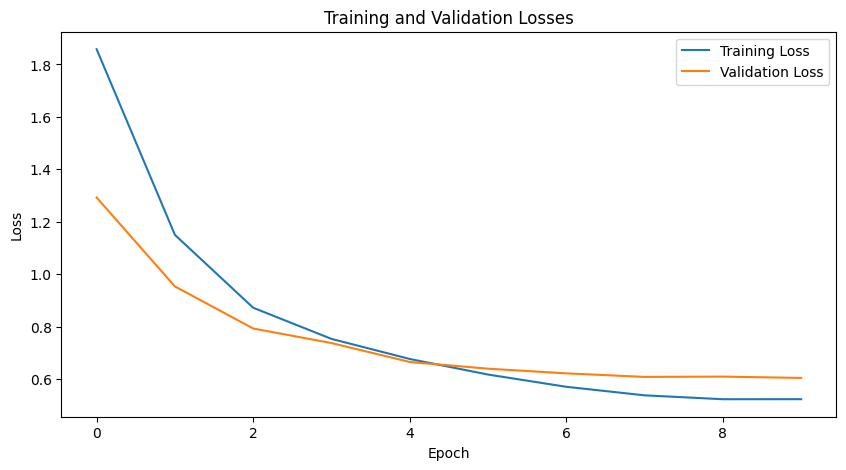

In [4]:
trainer.plot_metrics()
# trainer.visualize_predictions()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6691678..2.7934468].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6691678..2.8599157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9480077..2.933711].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.485467..3.2587297].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0398593..3.1701043].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3358073..3.280886].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.420364..2

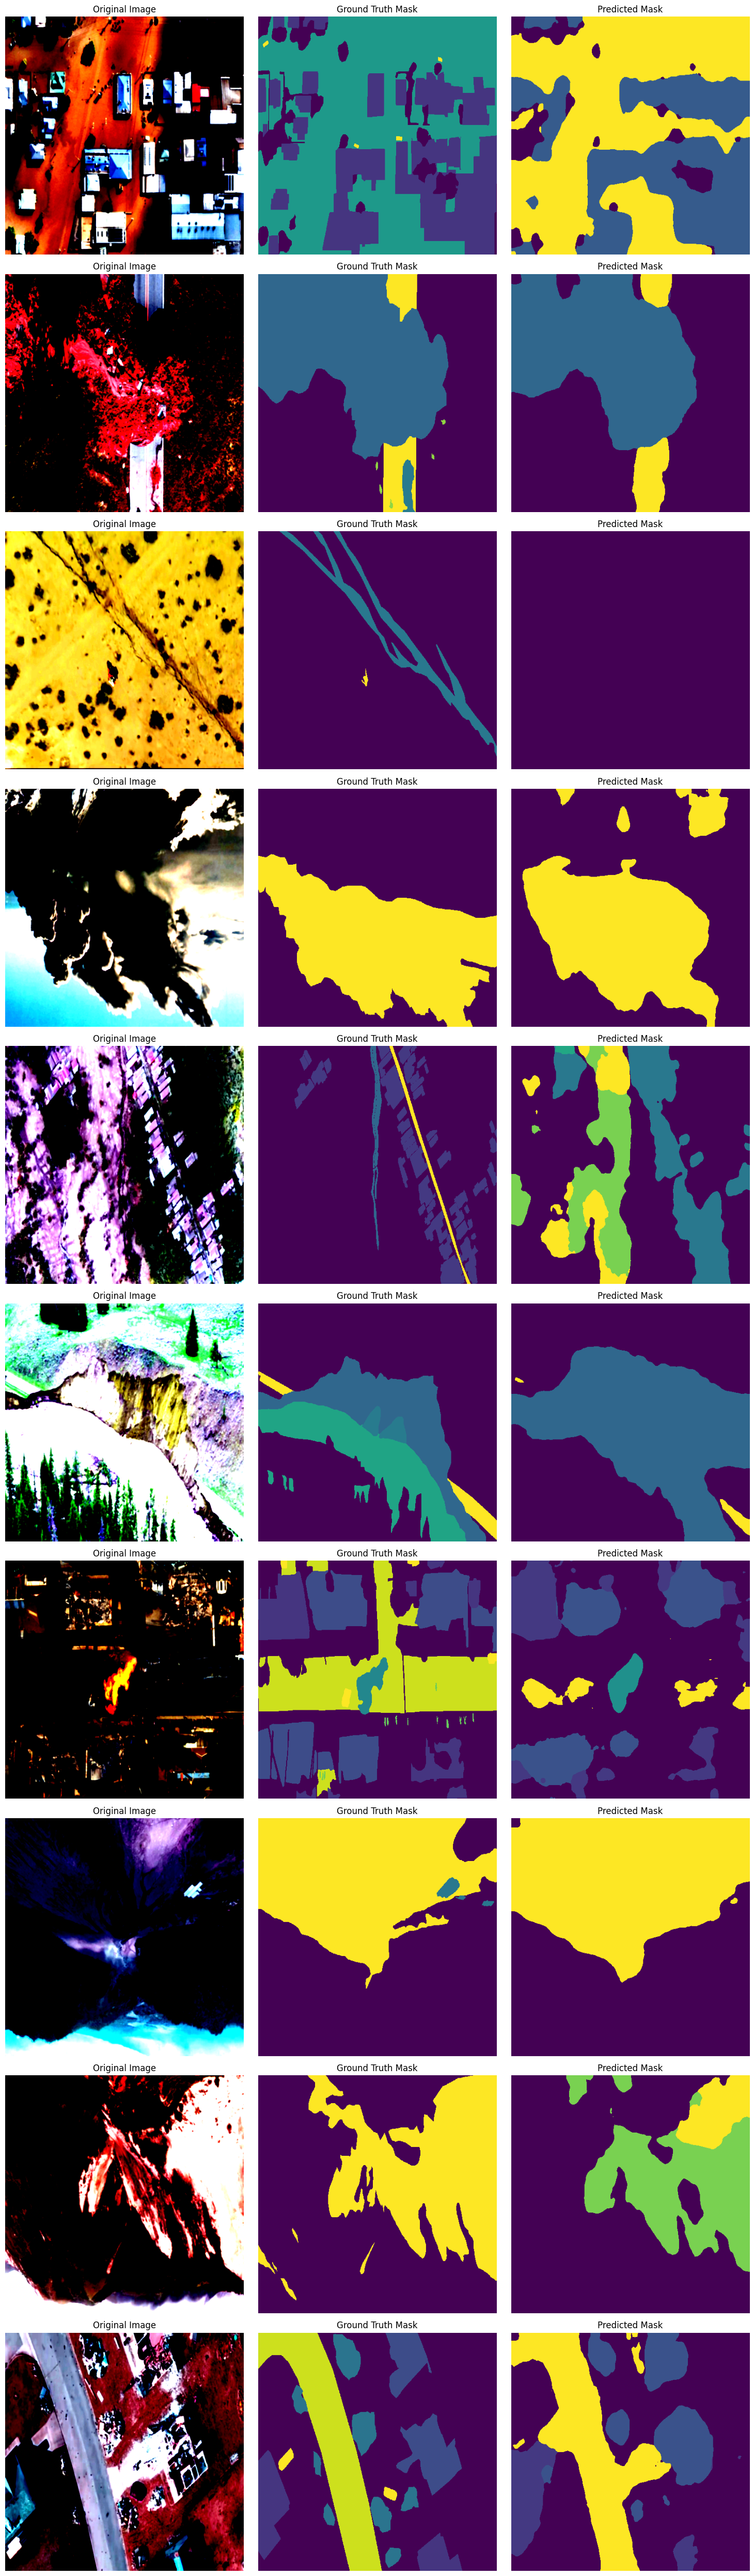

In [5]:
trainer.visualize_predictions(num_samples=10)